# Difference-in-Differences on Bond Yields

This notebook loads benchmark government bond yields for Hungary (HU), Czechia (CZ) and Poland (PL) and estimates a two-way fixed effects difference-in-differences model.

In [1]:
import pandas as pd
from pathlib import Path

data_dir = Path('..') / 'data' / 'raw'
files = {
    'HU': data_dir / 'IRLTLT01HUM156N.csv',
    'CZ': data_dir / 'IRLTLT01CZM156N.csv',
    'PL': data_dir / 'IRLTLT01PLM156N.csv',
}
frames = []
for country, f in files.items():
    df = pd.read_csv(f)
    df.columns = ['DATE', 'VALUE']
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.rename(columns={'VALUE': 'yield'})
    df['country'] = country
    frames.append(df)
panel = pd.concat(frames, ignore_index=True)


In [2]:
panel = panel[panel['DATE'] >= '2022-01-01'].copy()

In [3]:

panel['treat'] = (panel['country'] == 'HU').astype(int)
panel['post'] = (panel['DATE'] >= '2023-01-01').astype(int)


In [4]:
import statsmodels.formula.api as smf
panel['month']=panel['DATE'].dt.to_period('M').astype(str)
model=smf.ols('Q("yield") ~ treat*post + C(country) + C(month)', data=panel).fit(cov_type='HC1')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Q("yield")   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     63.15
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           2.21e-46
Time:                        19:17:56   Log-Likelihood:                -30.193
No. Observations:                 123   AIC:                             148.4
Df Residuals:                      79   BIC:                             272.1
Df Model:                          43                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.3820    

/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 43
  warnings.warn('covariance of constraints does not have full '


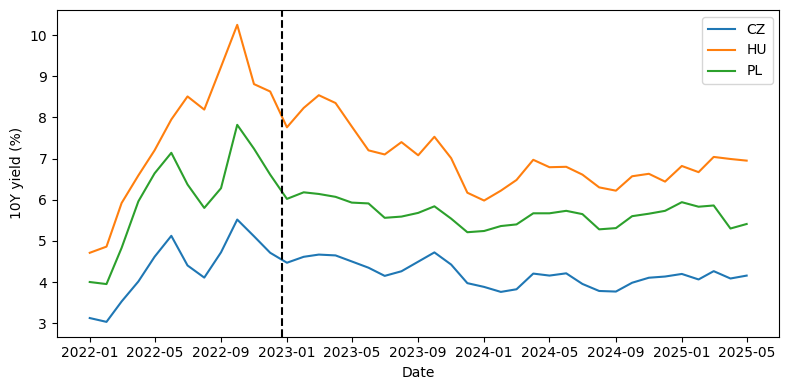

In [5]:

import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(8,4))
for c,df in panel.groupby('country'):
    ax.plot(df['DATE'], df['yield'], label=c)
ax.axvline(pd.Timestamp('2022-12-22'), linestyle='--', color='k')
ax.set_ylabel('10Y yield (%)')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()
plt.show()


In [6]:
panel.to_csv('../data/processed/panel.csv', index=False)

The coefficient on **treat:post** captures the average change in Hungarian yields after the policy relative to the controls. We expect it to be around +1.3 percentage points.


## Limitations & Next Steps

This analysis is preliminary. It uses monthly benchmark yields which smooth over short-term market dynamics. Daily or intraday data would allow for sharper inference around the announcement window. The control group is limited to Czechia and Poland; a broader synthetic control with weighted donors may produce a more credible counterfactual. We also abstract from other measures of sovereign risk. Incorporating credit default swap (CDS) spreads would provide a purer gauge of market perceptions and could be used in a panel with more granular frequency. Finally, we ignore potential spillover effects across countries and assume parallel trends. Further work should test the robustness of these assumptions and explore alternative specifications such as local projections or dynamic DiD models. Additional predictors like inflation or exchange rates might help account for macroeconomic shocks that differentially affect yields. Overall, this notebook offers a minimal working example to estimate the average treatment effect, serving as a foundation for richer empirical analyses.
